In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

The tf–idf is the product of two statistics, term frequency and inverse document frequency. There are various ways for determining the exact values of both statistics.

The score to be built in this part aims to define the importance of a keyword or phrase within a the database.

## import pkgs

In [616]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pymongo
import argparse
from configparser import ConfigParser
import os
import json

## Connect to MongoDB 

In [617]:
config = ConfigParser()
pardir = os.getcwd()
config.read('secrets.ini')

['secrets.ini']

In [618]:
DB_USER = config['MONGODB']['CKIDS_USER']
DB_PASS = config['MONGODB']['CKIDS_PASS']
DB_NAME = config['MONGODB']['CKIDS_DB_NAME']
HOST = config['AWS']['HOST_IP']
PORT = config['AWS']['HOST_PORT']
client = pymongo.MongoClient("mongodb://{DB_USER}:{DB_PASS}@{HOST}:{PORT}/{DB_NAME}".format(
    DB_USER=DB_USER, DB_PASS=DB_PASS, HOST=HOST, PORT=PORT, DB_NAME=DB_NAME))
db = client[DB_NAME]
collection = db["raw_artifacts"]
result = collection.find()

## Get Data from DB

In [619]:
objID_data = {}
for obj in result:
    description = obj['description']
#     if description != '':
#         description_data += [description]
    try:
        keywords = ' '.join(obj['keywords'])
    except KeyError:
        keywords = ''
        None
#     keywords_data += [keywords]    
    title = obj['title']
#     if title != '':
#         title_data += [title]
    objID_data[obj['_id']] = title+' '+description+' '+keywords

## Calculate TFIDF scores

### Reprocess keyword list

In [808]:
kw_csv = pd.read_csv('final_kw_list.csv', index_col=0)

In [809]:
term_list = list(kw_csv["Other_word_to_match"].str.split(', '))

In [811]:
def tf(term_list, documents):
    """
    Calculate term frequency for 'term'.
    
    input:
    ------
    term_list: the keyword to be evaluated, with options. np array, shape=(T, 2)
    document: a document(here description paragraph string)
    
    output:
    -------
    a numerical frequency value.
    """
    N, T = len(documents),len(term_list)
    TF = np.zeros((N, T))
    for j in range(N):
        d = documents[j].lower()
        for i in range(T):
            word_options = term_list[i]
            TF[j, i] = sum([d.count(w.lower()) for w in word_options])
    return TF

In [812]:
def idf(TF):
    """
    Calculate inverse document frequency for term wrt all documents.
    
    input:
    ------
    TF: term frequency, numpy array (#documents, #terms)
    
    output:
    -------
    numpy array (#terms), numerical values of idfs
    """
    N = TF.shape[0]
    return np.log(N/1+np.count_nonzero(TF, axis=0))

In [813]:
TF = tf(term_list, list(objID_data.values()))

IDF = idf(TF)

TFIDF = TF*IDF

In [814]:
pd.DataFrame({'Keyword':[t[0].strip(' ') for t in term_list], 'Term_frequency':TF.sum(axis=0),
              'TFIDF_score':TFIDF.sum(axis=0), 
              'Log_TFIDF_score':np.log(TFIDF.sum(axis=0)+1)}).to_csv('final_kw_TFIDF_Score.csv')

## Calculate Relevance Scores

In [815]:
weight = pd.read_csv('final_kw_TFIDF_Score.csv', index_col=0)

# kw_weights = dict(weight[['Keyword','TFIDF_score']].to_numpy())

In [816]:
log_doc_scores = np.log(TF@(weight['TFIDF_score'].to_numpy())+1)

In [817]:
doc_scores_result = dict(zip([str(k) for k in objID_data.keys()],log_doc_scores))

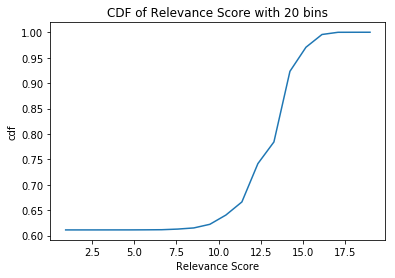

In [818]:
import matplotlib.pyplot as plt

# Choose how many bins you want here
num_bins = 20

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(log_doc_scores, bins=num_bins)

# Now find the cdf
cdf = np.cumsum(counts)/len(log_doc_scores)

# And finally plot the cdf
plt.plot(bin_edges[1:], cdf)
plt.xlabel('Relevance Score')
plt.ylabel('cdf')
plt.title("CDF of Relevance Score with {0} bins".format(num_bins))
plt.savefig('rlv_score_cdf.png')
plt.show()

In [819]:
with open('final_filter_TFIDF_result.json', 'w') as f:
    json.dump(doc_scores_result, f)

## Generate Samples

In [820]:
import json
from bson.objectid import ObjectId

In [821]:
# The web framework gets post_id from the URL and passes it as a string
def get(post_id):
    # Convert from string to ObjectId:
    document = collection.find_one({'_id': ObjectId(post_id)})
    return document

In [822]:
def match_words(l,j, term_list):
    stf = {}
    sample_data = []
    terms = tf(term_list, objID_data[ObjectId(l)]).sum(axis=0)
    stf = {}
    for i in range(len(terms)):
        if terms[i] > 0:
            stf [term_list[i]] = int(terms[i])
    sample_data += [['https://doi.org/'+get(l)['doi'], stf, np.log(j)]]
    return sample_data

In [823]:
with open('final_filter_TFIDF_result.json') as f:
    doc_score_data = json.load(f)

In [824]:
len(doc_score_data)

277810

In [834]:
ct0 = 0
ct13 = 0
for i, g in doc_score_data.items():
    if g <= 0.1:
        ct0 += 1
    if g <= 13:
        ct13 += 1
print(ct0, ct13)

169799 215338


In [836]:
low0 = sorted(doc_score_data.items(), key=lambda x:x[1])[:10]
low_n0 = sorted(doc_score_data.items(), key=lambda x:x[1])[ct0+11:ct0+21]
middle = sorted(doc_score_data.items(), key=lambda x:x[1])[ct13+1:ct13+11]
high = sorted(doc_score_data.items(), key=lambda x:x[1])[-10:]

In [837]:
sample_data = []
sdata = low0+low_n0+middle+high

for i in range(len(sdata)):
    l, j = sdata[i]
    stf = {}
    for i in range(len(term_list)):
        word_options = term_list[i]
        d = objID_data[ObjectId(l)].lower()
        fq = sum([d.count(w.lower()) for w in word_options])
        if fq >=1 :
            stf[term_list[i][0]] = fq    
    sample_data += [['https://doi.org/'+get(l)['doi'], stf, j]]

In [838]:
sd = pd.DataFrame(sample_data, columns = ['url', 'term:frequency', 'log score'])

In [839]:
sd['score category'] = ['zero']*10+['low']*10+['middle']*10+['high']*10

In [840]:
sd

,url,term:frequency,log score,score category
0,https://doi.org/10.5281/zenodo.3545811,{},0.000000,zero
1,https://doi.org/10.5281/zenodo.3515458,{},0.000000,zero
2,https://doi.org/10.5281/zenodo.3597391,{},0.000000,zero
3,https://doi.org/10.5281/zenodo.344492,{},0.000000,zero
4,https://doi.org/10.5281/zenodo.1133037,{},0.000000,zero
5,https://doi.org/10.5281/zenodo.1314827,{},0.000000,zero
6,https://doi.org/10.5281/zenodo.376969,{},0.000000,zero
7,https://doi.org/10.5281/zenodo.177215,{},0.000000,zero
8,https://doi.org/10.5281/zenodo.1099416,{},0.000000,zero
9,https://doi.org/10.5281/zenodo.16414,{},0.000000,zero


In [841]:
sd.to_csv('final_samples_w_scores.csv')

## Scrach Cells...

In [365]:
x = pd.read_csv('keywords_for_TFIDF.csv', index_col=0)

In [375]:
'worm' in x['Keywords'].to_numpy()

True

In [358]:

index_to_drop=[71, 174, 175]
x.iloc[index_to_drop]

,Keywords
71,and
174,of
175,on


In [364]:
x.drop(index=index_to_drop).reset_index(drop=True).to_csv('keywords_for_TFIDF.csv')

In [290]:
def tf_stale(term_list, documents):
    """
    Calculate term frequency for 'term'.
    
    input:
    ------
    term: the keyword to be evaluated.
    document: a document(here description paragraph string)
    
    output:
    -------
    a numerical frequency value.
    """
    N, T = len(documents), len(term_list)
    TF = np.zeros((N, T))
    for i in range(T):
        for j in range(N):
            # match both 'ab-cd' and 'ab cd'
            if '-' in term_list[i]:
                word = term_list[i].replace('-', ' ')
                TF[j, i] = documents[j].lower().split().count(word.lower()) \
                            + documents[j].lower().split().count(term_list[i].lower())
            else:
                TF[j, i] = documents[j].lower().split().count(term_list[i].lower())
    return TF

In [299]:
def tf2_stale(term_list, documents):
    """
    Calculate term frequency for 'term'.
    
    input:
    ------
    term: the keyword to be evaluated.
    document: a document(here description paragraph string)
    
    output:
    -------
    a numerical frequency value.
    """
    N, T = len(documents), len(term_list)
    TF = np.zeros((N, T))
    for i in range(T):
        for j in range(N):
            d = documents[j].lower().split()
            # match both 'ab-cd' and 'ab cd'
            if '-' in term_list[i]:
                word = term_list[i].replace('-', ' ')
                TF[j, i] = d.count(word.lower()) \
                            + d.count(term_list[i].lower())
            else:
                TF[j, i] = d.count(term_list[i].lower())
    return TF

In [173]:
len(data)

2280318

In [169]:
len(description_data)

834050

In [170]:
len(keywords_data)

612069

In [171]:
len(title_data)

834199

for d in data:
    if d == '':
        data.remove(d)

len(data)

keyword_data = pd.read_csv('v3_CKIDS_keywords_with_frequency.csv', index_col=0)

def process_term_list(term_list):
    term_list2 = []
    for t in term_list:
        if '-' in t:
            term_list2 += [t, t.replace('-', ' ')]
        if "(" and ")" in t:
            tt = t.split("(")
            if tt[0] == '':
                term_list2 += [tt[1].replace(")","")]
            term_list2 += [tt[0].rstrip(" "), tt[1].replace(")","")]
        else:
            term_list2 += [t]
    return term_list2

term_list = process_term_list(keyword_data['Word'].unique())
term_list = set(term_list)

term_list.discard('')

term_list = list(term_list)

pd.DataFrame(sorted(term_list), columns=['Keywords']).to_csv('keywords_for_TFIDF.csv')

### some maunal process with plurals ...

term_list = term_list.unique()

tl = []
for t in term_list:
    tl += t.split()

tl_df = pd.DataFrame(sorted(tl), columns=['Keywords'])

tl = tl_df['Keywords'].unique()

np.pop(tl, 'attacks')

for t in tl:
     if t[-1] == 's':
            print(t)

In [30]:
#vectorizer = TfidfVectorizer(vocabulary=term_list, use_idf=False)
#X = vectorizer.fit_transform(description_data)
#X.todense().sum(axis=0)
#pd.DataFrame({'Keyword':term_list, 'TFIDF_score':X.toarray().sum(axis=0)}).to_csv('kw_score_TFIDF.csv')

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
integrety SSL TLS decryption

In [ ]:
# old--brush keywords list
# keyword_data = pd.read_csv('v3_CKIDS_keywords_with_frequency.csv', index_col=0)
# def process_term_list(term_list):
#     term_list2 = []
#     for t in term_list:
#         # remove hyphens
#         if '-' in t:
#             term_list2 += [t.replace('-', ' ')]
#         # separate terms with brackets
#         elif "(" and ")" in t:
#             tt = t.split("(")
#             if tt[0] == '':
#                 term_list2 += [tt[1].replace(")","")]
#             term_list2 += [tt[0].rstrip(" "), tt[1].replace(")","")]
#         else:
#             term_list2 += [t]
#     return term_list2
# term_list = process_term_list(keyword_data['Word'].unique())
# term_list = set(term_list)
# term_list.discard('')
# term_list = sorted(list(term_list))

In [148]:
ct = 0
for i, g in data.items():
    if g == 0:
        ct += 1
    elif g < 0:
        print(i,j)

In [306]:
def tf_stale(term_list, documents):
    """
    Calculate term frequency for 'term'.
    
    input:
    ------
    term: the keyword to be evaluated.
    document: a document(here description paragraph string)
    
    output:
    -------
    a numerical frequency value.
    """
    N, T = len(documents), len(term_list)
    TF = np.zeros((N, T))
    for j in range(N):
        d = documents[j].lower().split()
        for i in range(T):
            # match both 'ab-cd' and 'ab cd'
            if '-' in term_list[i]:
                word = term_list[i].replace('-', ' ')
                TF[j, i] = d.count(word.lower()) \
                            + d.count(term_list[i].lower())
            else:
                TF[j, i] = d.count(term_list[i].lower())
    return TF

In [321]:
%%time
filtered_obj = {}
for objid, content in objID_data.items():
    document = ' '.join(content)
    filtered_obj[str(objid)] = calculate_doc_score(document, kw_weights)

CPU times: user 7min 21s, sys: 5.6 s, total: 7min 26s
Wall time: 7min 25s


In [316]:
def calculate_doc_score_stale(document, kw_weights):
    """
    document: str
    kw_weights: dict
    """
    relev_freq = []
    d = document.lower().split()
    for kw in kw_weights.keys():
        if '-' in kw:
            kw2 = kw.replace('-', ' ')
            relev_freq += [d.count(kw.lower()) \
                        + d.count(kw2.lower())]
        else:
            relev_freq += [d.count(kw.lower())]
    relev_score = np.dot(list(kw_weights.values()),relev_freq)
    return relev_score